# Exploratory data analysis

In [1]:
from fraudetect.dataset import load_data
import numpy as np

In [2]:
df_data = load_data("../data/training.csv")

## Correlation

In [3]:
# correlation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

def cramers_v_matrix(df):
    cat_cols = ['PricingStrategy', 'ChannelId', 'ProviderId', 'ProductCategory',
                'SubscriptionId',
                 'ProductId','TX_FRAUD','CUSTOMER_ID','AccountId']
    # cat_cols = df.select_dtypes(include=['object', 'category', 'string']).columns
    matrix = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))),
                          index=cat_cols, columns=cat_cols)
    for col1 in cat_cols:
        for col2 in cat_cols:
            matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
    return matrix


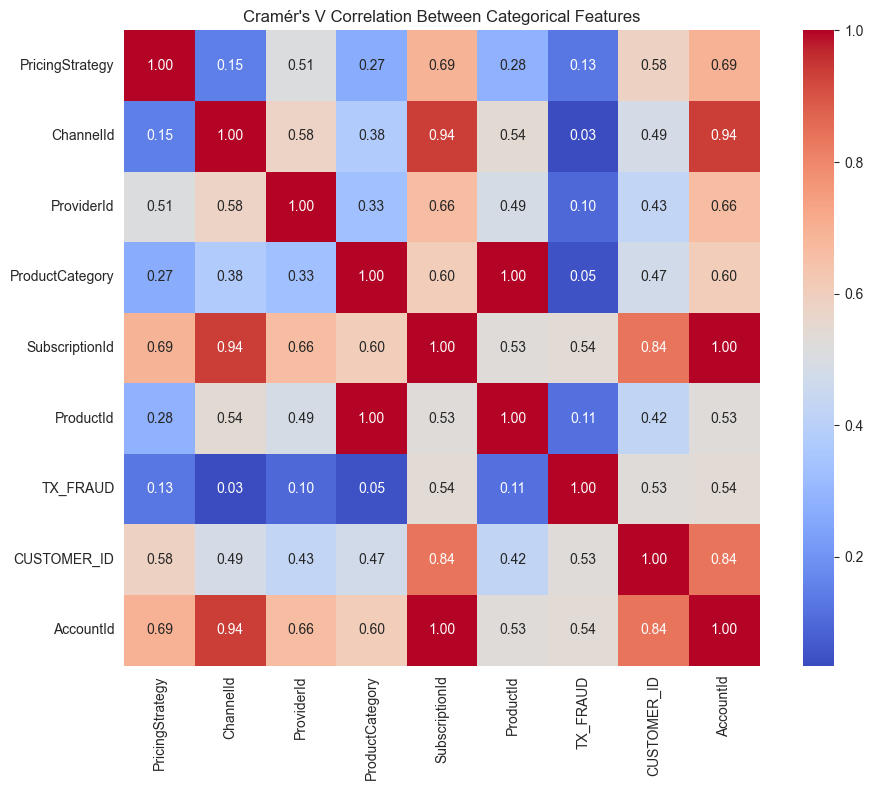

In [4]:
# --- Example usage ---
# df = pd.read_csv("your_data.csv")  # or however you load your DataFrame
cramers_matrix = cramers_v_matrix(df_data)

# --- Plot heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Cramér's V Correlation Between Categorical Features")
plt.tight_layout()
plt.show()

In [5]:
pred_data = load_data(r"D:\fraud-detection-galsen\data\test.csv")

In [6]:
df_data.head(3)

,TRANSACTION_ID,BatchId,AccountId,SubscriptionId,CUSTOMER_ID,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,TX_AMOUNT,Value,TX_DATETIME,PricingStrategy,TX_FRAUD,TX_TIME_DAYS
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0,0


In [7]:
# Time Coverage
df_data['TX_DATETIME'].iloc[-1] - df_data['TX_DATETIME'].iloc[0]

Timedelta('90 days 07:42:39')

In [8]:
cols = ['AccountId', 'CUSTOMER_ID','SubscriptionId']
df_demo = df_data[cols].apply(lambda x: "+".join(x), axis=1,raw=False,result_type='reduce')
df_demo

0        AccountId_3957+CustomerId_4406+SubscriptionId_887
1        AccountId_4841+CustomerId_4406+SubscriptionId_...
2        AccountId_4229+CustomerId_4683+SubscriptionId_222
3         AccountId_648+CustomerId_988+SubscriptionId_2185
4        AccountId_4841+CustomerId_988+SubscriptionId_3829
                               ...                        
95657    AccountId_4841+CustomerId_3078+SubscriptionId_...
95658    AccountId_3439+CustomerId_3874+SubscriptionId_...
95659    AccountId_4841+CustomerId_3874+SubscriptionId_...
95660    AccountId_1346+CustomerId_1709+SubscriptionId_652
95661    AccountId_4841+CustomerId_1709+SubscriptionId_...
Length: 95662, dtype: object

In [9]:
df_demo.nunique()

8222

## Understand features

In [10]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   TRANSACTION_ID   95662 non-null  category           
 1   BatchId          95662 non-null  category           
 2   AccountId        95662 non-null  category           
 3   SubscriptionId   95662 non-null  category           
 4   CUSTOMER_ID      95662 non-null  category           
 5   CurrencyCode     95662 non-null  category           
 6   CountryCode      95662 non-null  category           
 7   ProviderId       95662 non-null  category           
 8   ProductId        95662 non-null  category           
 9   ProductCategory  95662 non-null  category           
 10  ChannelId        95662 non-null  category           
 11  TX_AMOUNT        95662 non-null  Float64            
 12  Value            95662 non-null  Int64              
 13  TX_DATETIME     

In [11]:
df_data['ChannelId'].unique()

['ChannelId_3', 'ChannelId_2', 'ChannelId_1', 'ChannelId_5']
Categories (4, string): [ChannelId_1, ChannelId_2, ChannelId_3, ChannelId_5]

In [12]:
df_data['Value']/df_data['TX_AMOUNT']

0         1.0
1        -1.0
2         1.0
3        1.09
4        -1.0
         ... 
95657    -1.0
95658     1.0
95659    -1.0
95660     1.0
95661    -1.0
Length: 95662, dtype: Float64

In [13]:
df_data.nunique()/len(df_data)

TRANSACTION_ID     1.000000
BatchId            0.991083
AccountId          0.037977
SubscriptionId     0.037915
CUSTOMER_ID        0.039117
CurrencyCode       0.000010
CountryCode        0.000010
ProviderId         0.000063
ProductId          0.000240
ProductCategory    0.000094
ChannelId          0.000042
TX_AMOUNT          0.017520
Value              0.015858
TX_DATETIME        0.988438
PricingStrategy    0.000042
TX_FRAUD           0.000021
TX_TIME_DAYS       0.000951
dtype: float64

In [14]:
df_data.nunique()

TRANSACTION_ID     95662
BatchId            94809
AccountId           3633
SubscriptionId      3627
CUSTOMER_ID         3742
CurrencyCode           1
CountryCode            1
ProviderId             6
ProductId             23
ProductCategory        9
ChannelId              4
TX_AMOUNT           1676
Value               1517
TX_DATETIME        94556
PricingStrategy        4
TX_FRAUD               2
TX_TIME_DAYS          91
dtype: int64

In [15]:
pred_data.nunique()

TRANSACTION_ID     45019
BatchId            44684
AccountId           2471
SubscriptionId      2470
CUSTOMER_ID         5018
CurrencyCode           1
CountryCode            1
ProviderId             6
ProductId             26
ProductCategory        9
ChannelId              5
TX_AMOUNT            998
Value                944
TX_DATETIME        44018
PricingStrategy        4
TX_TIME_DAYS          30
dtype: int64

In [20]:
for col in ['ChannelId','ProductCategory','ProductId','ProviderId','PricingStrategy']:
    vals_pred = sorted(pred_data[col].unique())
    vals_train = sorted(df_data[col].unique())

    intersec = np.intersect1d(vals_pred,vals_train)

    is_same = len(intersec) == len(vals_pred)
    if not is_same:
        print("===",col,"===")
        print('pred: ',vals_pred,'\ntrain:',vals_train,'\n\n')



=== ChannelId ===
pred:  ['ChannelId_1', 'ChannelId_2', 'ChannelId_3', 'ChannelId_4', 'ChannelId_5'] 
train: ['ChannelId_1', 'ChannelId_2', 'ChannelId_3', 'ChannelId_5'] 


=== ProductCategory ===
pred:  ['airtime', 'data_bundles', 'financial_services', 'movies', 'retail', 'ticket', 'transport', 'tv', 'utility_bill'] 
train: ['airtime', 'data_bundles', 'financial_services', 'movies', 'other', 'ticket', 'transport', 'tv', 'utility_bill'] 


=== ProductId ===
pred:  ['ProductId_1', 'ProductId_10', 'ProductId_11', 'ProductId_13', 'ProductId_14', 'ProductId_15', 'ProductId_16', 'ProductId_17', 'ProductId_18', 'ProductId_19', 'ProductId_2', 'ProductId_20', 'ProductId_21', 'ProductId_22', 'ProductId_23', 'ProductId_24', 'ProductId_25', 'ProductId_26', 'ProductId_27', 'ProductId_3', 'ProductId_4', 'ProductId_5', 'ProductId_6', 'ProductId_7', 'ProductId_8', 'ProductId_9'] 
train: ['ProductId_1', 'ProductId_10', 'ProductId_11', 'ProductId_12', 'ProductId_13', 'ProductId_14', 'ProductId_15', 'Pr

<StringArray>
['ChannelId_3', 'ChannelId_2', 'ChannelId_1', 'ChannelId_5']
Length: 4, dtype: string

In [7]:
df_data.dtypes

TransactionId                        object
BatchId                              object
AccountId                            object
SubscriptionId                       object
CustomerId                           object
CurrencyCode                         object
CountryCode                           int64
ProviderId                           object
ProductId                            object
ProductCategory                      object
ChannelId                            object
Amount                              float64
Value                                 int64
TransactionStartTime    datetime64[ns, UTC]
PricingStrategy                       int64
FraudResult                           int64
dtype: object

In [8]:
columns_to_drop = ['BatchId','CurrencyCode','CountryCode']

In [11]:
stats_normal = df_data.loc[df_data['FraudResult']==0].describe()
stats_normal

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95469.0,9.546900e+04,9.546900e+04,95469.000000,95469.0
mean,256.0,3.627723e+03,6.763227e+03,2.257089,0.0
std,0.0,4.035711e+04,3.999484e+04,0.731971,0.0
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.0
25%,256.0,-5.000000e+01,2.500000e+02,2.000000,0.0
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.0
75%,256.0,2.500000e+03,5.000000e+03,2.000000,0.0
max,256.0,2.400000e+06,2.400000e+06,4.000000,0.0


In [12]:
stats_fraud = df_data.loc[df_data['FraudResult']==1].describe()
stats_fraud

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,193.0,1.930000e+02,1.930000e+02,193.000000,193.0
mean,256.0,1.535272e+06,1.561820e+06,1.704663,1.0
std,0.0,2.100525e+06,2.081227e+06,0.963300,0.0
min,256.0,-9.000000e+05,5.000000e+02,0.000000,1.0
25%,256.0,5.000000e+05,5.000000e+05,2.000000,1.0
50%,256.0,6.000000e+05,6.500000e+05,2.000000,1.0
75%,256.0,2.000000e+06,2.000000e+06,2.000000,1.0
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.0


In [ ]:
# we see that the Amount is very large in Frauds
stats_fraud/stats_normal

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,0.002022,0.002022,0.002022,0.002022,0.002022
mean,1.000000,423.205557,230.928166,0.755249,inf
std,NaN,52.048457,52.037401,1.316035,NaN
min,1.000000,0.900000,250.000000,NaN,inf
25%,1.000000,-10000.000000,2000.000000,1.000000,inf
50%,1.000000,600.000000,650.000000,1.000000,inf
75%,1.000000,800.000000,400.000000,1.000000,inf
max,1.000000,4.116667,4.116667,1.000000,inf


### Understand CustomerId, accountId, SubscriptionId

In [9]:
identifiers = ['SubscriptionId','AccountId','CustomerId']

In [10]:
df_data[identifiers].nunique()

SubscriptionId    3627
AccountId         3633
CustomerId        3742
dtype: int64

In [11]:
df_data.groupby(identifiers[:-1]).nunique()[identifiers[-1:]]

,,CustomerId
SubscriptionId,AccountId,
SubscriptionId_10,AccountId_2708,1
SubscriptionId_1000,AccountId_3421,1
SubscriptionId_1001,AccountId_1297,1
SubscriptionId_1002,AccountId_1344,1
SubscriptionId_1004,AccountId_4474,1
...,...,...
SubscriptionId_993,AccountId_4674,1
SubscriptionId_995,AccountId_3226,1
SubscriptionId_997,AccountId_2575,1


In [12]:
# subscriptionId and AccountID are not sufficient to identify a unique person doing a transaction

(df_data.groupby(identifiers[:-1]).nunique()[identifiers[-1:]]>1).sum()

CustomerId    10
dtype: int64

In [13]:
df_data.groupby(identifiers[1:]).nunique()[identifiers[:1]]

SubscriptionId
AccountId     CustomerId                     
AccountId_1   CustomerId_46                 1
AccountId_10  CustomerId_1074               1
              CustomerId_1093               1
              CustomerId_1096               1
              CustomerId_1156               1
...                                       ...
AccountId_99  CustomerId_420                1
AccountId_990 CustomerId_1339               1
AccountId_992 CustomerId_1341               1
AccountId_994 CustomerId_1343               1
AccountId_998 CustomerId_1349               1

[8222 rows x 1 columns]

In [14]:
# We can drop the ``subscriptionId`` column if we keep both ``AccountId`` and ``CustomerId``

(df_data.groupby(identifiers[1:]).nunique()[identifiers[:1]]>1).sum()

SubscriptionId    0
dtype: int64

In [15]:
df_data.groupby(['SubscriptionId','CustomerId']).nunique()['AccountId']

SubscriptionId       CustomerId     
SubscriptionId_10    CustomerId_3128    1
SubscriptionId_1000  CustomerId_3855    1
SubscriptionId_1001  CustomerId_1659    1
SubscriptionId_1002  CustomerId_1707    1
SubscriptionId_1004  CustomerId_4934    1
                                       ..
SubscriptionId_993   CustomerId_5142    1
SubscriptionId_995   CustomerId_3654    1
SubscriptionId_997   CustomerId_2992    1
SubscriptionId_998   CustomerId_4636    1
SubscriptionId_999   CustomerId_1210    1
Name: AccountId, Length: 6545, dtype: int64

In [16]:
# subscriptionId and CustomerId are not sufficient to identify a unique person doing a transaction
(df_data.groupby(['SubscriptionId','CustomerId']).nunique()[['AccountId']] > 1).sum()

AccountId    1677
dtype: int64

In [17]:
# discard 'SubscriptionId' column
columns_to_drop.append('SubscriptionId')

# Train-test split

The train-test split should be done in a way that we have different customers in the training and test set


### functions

In [57]:
from fraudetect.dataset import train_test_split
from fraudetect.helpers import get_train_test_set
import matplotlib.pyplot as plt
import numpy as np

### debugging

In [ ]:
# renaming columns
rename_cols = {
    'FraudResult': 'TX_FRAUD',
    'Amount': 'TX_AMOUNT',
    'CustomerId': 'CUSTOMER_ID',
    'TransactionStartTime': 'TX_DATETIME',
    'TransactionId': 'TRANSACTION_ID',
}

df_data.rename(columns=rename_cols, inplace=True)
df_data.columns

Index(['TRANSACTION_ID', 'BatchId', 'AccountId', 'SubscriptionId',
       'CUSTOMER_ID', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'TX_AMOUNT', 'Value', 'TX_DATETIME',
       'PricingStrategy', 'TX_FRAUD', 'TX_TIME_DAYS'],
      dtype='object')

In [7]:
# create TX_TIME_DAYS column
df_data['TX_TIME_DAYS'] = (df_data['TX_DATETIME'] - df_data['TX_DATETIME'].min()).dt.days

# create TX_TIME_SECONDS column
# df_data['TX_TIME_SECONDS'] = (df_data['TX_DATETIME'] - df_data['TX_DATETIME'].min()).dt.seconds

In [8]:
# df_data.set_index('TX_DATETIME',inplace=True)
df_data.sort_values('TX_DATETIME',inplace=True,ascending=True)

In [9]:
df_data_copy = df_data.copy()
df_data_copy['Fraud_cumsum'] = df_data_copy['TX_FRAUD'].cumsum()

<Axes: title={'center': 'Fraud over time'}, xlabel='TX_DATETIME'>

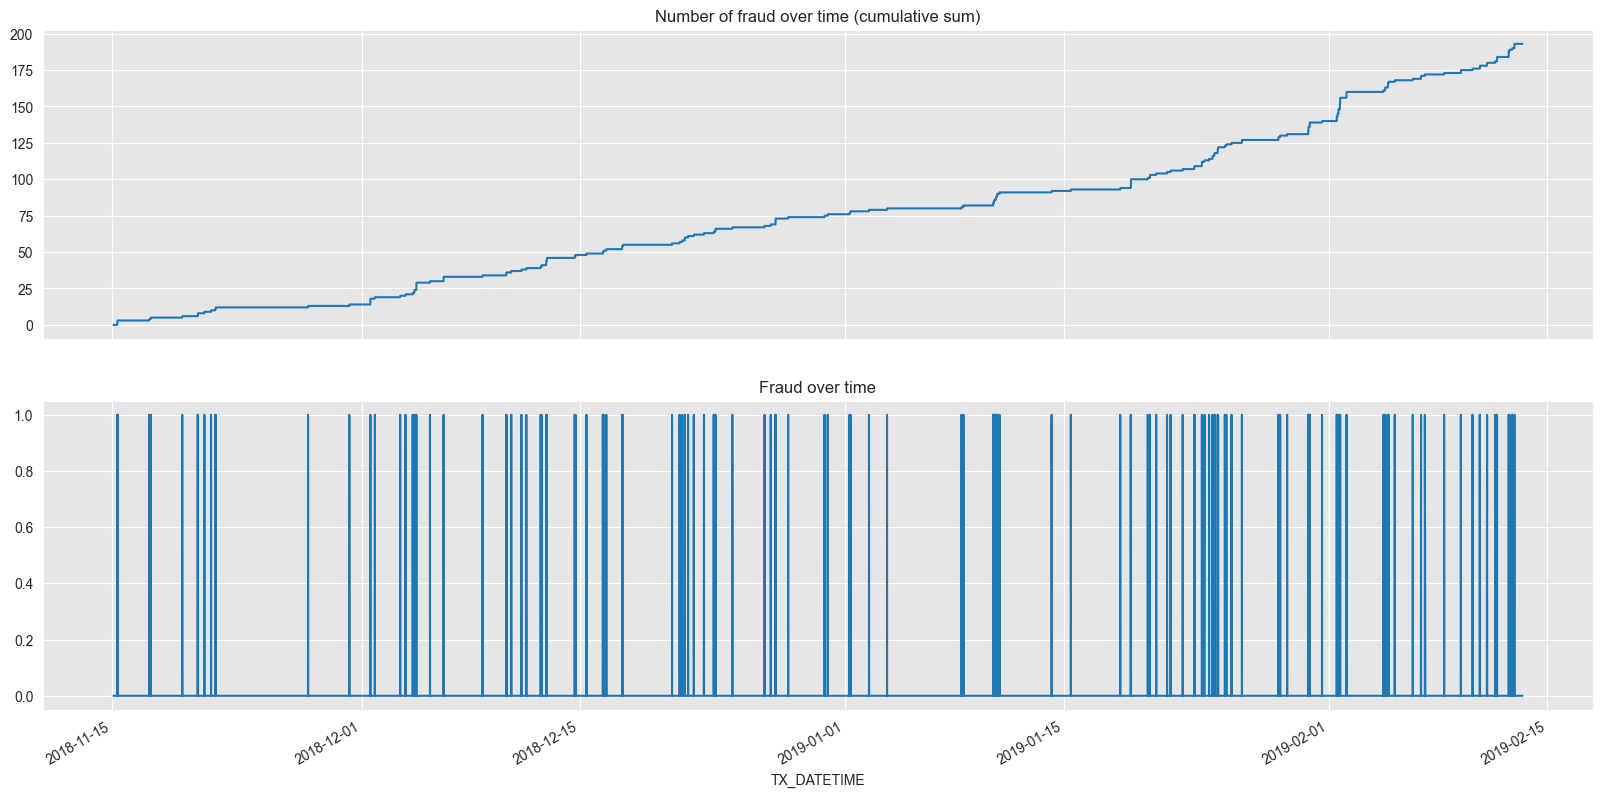

In [10]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
df_data_copy.plot(ax=axes[0], x='TX_DATETIME', y='Fraud_cumsum', title='Number of fraud over time (cumulative sum)', legend=False)

df_data_copy.plot(ax=axes[1], x='TX_DATETIME', y='TX_FRAUD', title='Fraud over time', legend=False)

In [11]:
# Set the starting day for the training period, and the deltas
start_date_training = df_data['TX_DATETIME'].iloc[0]
delta_train=62
delta_delay=7
delta_test=21

train_df, test_df = get_train_test_set(df_data,
                                    start_date_training=start_date_training,
                                    delta_train=delta_train,
                                    delta_test=delta_test,
                                    delta_delay=delta_delay,
                                    sampling_ratio=1.0
                                    )

In [12]:
# number of samples
train_df.shape[0], test_df.shape[0]

(61407, 25932)

In [13]:
# number of positive samples
train_df[train_df.TX_FRAUD==1].shape[0], test_df[test_df.TX_FRAUD==1].shape[0]

(93, 82)

In [14]:
# ratio of positive samples in Train set
round(train_df[train_df.TX_FRAUD==1].shape[0]/train_df.shape[0], 6)

0.001514

In [15]:
# ratio of positive samples in Test set
round(test_df[test_df.TX_FRAUD==1].shape[0]/test_df.shape[0], 6)

0.003162

In [16]:
# customers overlap between train and test set
customers_intersec = np.intersect1d(train_df['CUSTOMER_ID'].unique(), test_df['CUSTOMER_ID'].unique())
customers_intersec.shape

(893,)

In [17]:
# unique customers to train set
customers_unique_to_train = [a for a in train_df['CUSTOMER_ID'].unique() if a not in customers_intersec]
len(customers_unique_to_train), len(customers_unique_to_train)/len(train_df['CUSTOMER_ID'].unique())

(1870, 0.6768005790807093)

In [18]:
# unique customers to test set
customers_unique_to_test = [a for a in test_df['CUSTOMER_ID'].unique() if a not in customers_intersec]
len(customers_unique_to_test), len(customers_unique_to_test)/len(test_df['CUSTOMER_ID'].unique())

(865, 0.4920364050056883)

# Feature engineering

### functions

In [1]:
from fraudetect.dataset import load_data
from fraudetect.features import transform_data,build_encoder_scalers,perform_feature_engineering
from fraudetect.config import Arguments
from fraudetect.preprocessing.preprocessing import PolyInteractions, load_cat_encoding, load_workflow

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.impute import KNNImputer

import pandas as pd
import numpy as np


### categorical value encoding

In [2]:
pred_data = load_data(r"D:\fraud-detection-galsen\data\test.csv")
train_data = load_data(r"D:\fraud-detection-galsen\data\training.csv")

In [3]:
X_train = train_data.drop(columns=['TX_FRAUD'])
y_train = train_data['TX_FRAUD']
X_train.columns

Index(['TRANSACTION_ID', 'BatchId', 'AccountId', 'SubscriptionId',
       'CUSTOMER_ID', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'TX_AMOUNT', 'Value', 'TX_DATETIME',
       'PricingStrategy', 'TX_TIME_DAYS'],
      dtype='object')

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   TRANSACTION_ID   95662 non-null  category           
 1   BatchId          95662 non-null  category           
 2   AccountId        95662 non-null  category           
 3   SubscriptionId   95662 non-null  category           
 4   CUSTOMER_ID      95662 non-null  category           
 5   CurrencyCode     95662 non-null  category           
 6   CountryCode      95662 non-null  category           
 7   ProviderId       95662 non-null  category           
 8   ProductId        95662 non-null  category           
 9   ProductCategory  95662 non-null  category           
 10  ChannelId        95662 non-null  category           
 11  TX_AMOUNT        95662 non-null  Float64            
 12  Value            95662 non-null  Int64              
 13  TX_DATETIME     

In [5]:
X_train.nunique()

TRANSACTION_ID     95662
BatchId            94809
AccountId           3633
SubscriptionId      3627
CUSTOMER_ID         3742
CurrencyCode           1
CountryCode            1
ProviderId             6
ProductId             23
ProductCategory        9
ChannelId              4
TX_AMOUNT           1676
Value               1517
TX_DATETIME        94556
PricingStrategy        4
TX_TIME_DAYS          91
dtype: int64

In [6]:
X_train['ProductCategory'].unique()

['airtime', 'financial_services', 'utility_bill', 'data_bundles', 'tv', 'transport', 'ticket', 'movies', 'other']
Categories (9, string): [airtime, data_bundles, financial_services, movies, ..., ticket, transport, tv, utility_bill]

In [7]:
pred_data['ProductCategory'].unique()   

['airtime', 'financial_services', 'tv', 'utility_bill', 'data_bundles', 'movies', 'ticket', 'retail', 'transport']
Categories (9, string): [airtime, data_bundles, financial_services, movies, ..., ticket, transport, tv, utility_bill]

In [8]:
# X_t = X_train.drop(columns=['TRANSACTION_ID', 'BatchId',
#                             'CUSTOMER_ID', 
#                             'CurrencyCode', 'CountryCode'])

# ["binary", "count", "hashing", "base_n", "catboost","target_enc", "woe"]
# good choices: count, catboost, target_enc, woe
cat_encoder = load_cat_encoding(cat_encoding_method='catboost',drop_invariant=True,hash_n_components=12)

interact = PolyInteractions(cat_cols=['ChannelId','ProductCategory','AccountId',
                          'CurrencyCode','CountryCode','PricingStrategy',
                          'SubscriptionId','ProductId','ProviderId'],
                            cat_encoder=cat_encoder,
                            degree=3)

X_inter = interact.fit_transform(X=X_train,
                                 y=y_train
                                )
print(X_inter.shape)

(95662, 25)


In [10]:
X_inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   poly_inter_0   95662 non-null  float64
 1   poly_inter_1   95662 non-null  float64
 2   poly_inter_2   95662 non-null  float64
 3   poly_inter_3   95662 non-null  float64
 4   poly_inter_4   95662 non-null  float64
 5   poly_inter_5   95662 non-null  float64
 6   poly_inter_6   95662 non-null  float64
 7   poly_inter_7   95662 non-null  float64
 8   poly_inter_8   95662 non-null  float64
 9   poly_inter_9   95662 non-null  float64
 10  poly_inter_10  95662 non-null  float64
 11  poly_inter_11  95662 non-null  float64
 12  poly_inter_12  95662 non-null  float64
 13  poly_inter_13  95662 non-null  float64
 14  poly_inter_14  95662 non-null  float64
 15  poly_inter_15  95662 non-null  float64
 16  poly_inter_16  95662 non-null  float64
 17  poly_inter_17  95662 non-null  float64
 18  poly_i

In [11]:
interact.get_feature_names_out()

['poly_inter_0',
 'poly_inter_1',
 'poly_inter_2',
 'poly_inter_3',
 'poly_inter_4',
 'poly_inter_5',
 'poly_inter_6',
 'poly_inter_7',
 'poly_inter_8',
 'poly_inter_9',
 'poly_inter_10',
 'poly_inter_11',
 'poly_inter_12',
 'poly_inter_13',
 'poly_inter_14',
 'poly_inter_15',
 'poly_inter_16',
 'poly_inter_17',
 'poly_inter_18',
 'poly_inter_19',
 'poly_inter_20',
 'poly_inter_21',
 'poly_inter_22',
 'poly_inter_23',
 'poly_inter_24']

In [14]:
# X_inter

In [ ]:
# Running
args = Arguments()

args.random_state = 41 # for data prep

args.do_pca = False # try pca
args.do_poly_expansion = False


args.disable_pyod_outliers = False
args.pyod_detectors = ['abod', 'cblof', 'hbos', 'iforest', 'knn', 'loda', 'mcd', 'mo_gaal']

args.sampler_names = None
args.sampler_cfgs = None
args.disable_samplers = True

args.concat_features = None #("AccountId", "CUSTOMER_ID") # ("AccountId", "CUSTOMER_ID") or None
args.concat_features_encoding_kwargs = dict(
    cat_encoding_method="hashing", n_components=14
)

args.add_imputer = False # handle missing values at prediction time

args.cat_encoding_method = "base_n" # to handle unknown values effectively
args.cat_encoding_hash_n_components = 5  # if cat_encoding_method='hashing'
args.cat_encoding_base_n = 4  # if cat_encoding_method=base_n
args.windows_size_in_days = (1, 7, 30)

COLUMNS_TO_DROP = [
    "CurrencyCode",
    "CountryCode",
    "SubscriptionId",
    "BatchId",
    "CUSTOMER_ID",
    "AccountId",
    "TRANSACTION_ID",
    "TX_DATETIME",
    "TX_TIME_DAYS",
]
COLUMNS_TO_ONE_HOT_ENCODE = [
    "PricingStrategy",
    "ChannelId",
    "ProviderId",
]
COLUMNS_TO_CAT_ENCODE = ["ProductCategory", 
                         "ProductId", 
                        ]
COLUMNS_TO_STD_SCALE = [
    "TX_DURING_WEEKEND",
    "TX_DURING_NIGHT",
    "Value",
    "TX_AMOUNT",
    "TX_HOUR"
]
COLUMNS_TO_ROBUST_SCALE = []


if args.cat_encoding_method == "hashing":
    kwargs = dict(
        n_components=args.cat_encoding_hash_n_components,
        hash_method=args.cat_encoding_hash_method,
    )
elif args.cat_encoding_method == "base_n":
    kwargs = dict(
        base=args.cat_encoding_base_n,
    )
else:
    kwargs = dict()



In [12]:
from sklearn.metrics import pairwise_distances
import spacy
from functools import partial

def compute_similarity(s1: str, s2: str,nlp) -> float:
        """
        Override the default 2*M/T similarity with spaCy's doc.similarity().
        """
        # spaCy returns a float in [0,1] (if vectors are normalized).
        s1 = str(s1).replace("nan", "")
        s2 = str(s2).replace("nan", "")
        doc1 = nlp(s1)
        doc2 = nlp(s2)
        # Handle missing vectors: similarity=0 if doc2 has no vector
        if (not doc1.has_vector) or (not doc2.has_vector):
            return 0.0
        return float(doc1.similarity(doc2))

model_name="en_core_web_md"
nlp = spacy.load(model_name)
partial_compute_similarity = partial(compute_similarity, nlp=nlp)

In [16]:
set(['ProductCategory','CountryCode','CurrencyCode']) & set([
                                                            "CurrencyCode",
                                                            "CountryCode",
                                                            "SubscriptionId",
                                                            "BatchId",
                                                            "CUSTOMER_ID",
                                                            "AccountId",
                                                            "TRANSACTION_ID",
                                                            "TX_DATETIME",
                                                            "TX_TIME_DAYS",
                                                        ])

{'CountryCode', 'CurrencyCode'}

In [13]:
product_categories = X_train['ProductCategory'].unique().astype(str)
distances = pairwise_distances(product_categories, metric=partial_compute_similarity)
distances.shape

(9, 9)

In [9]:
model_name="en_core_web_md"
similarity_encoder = load_cat_encoding(cat_encoding_method='similarity',
                                       nlp_model_name=model_name,
                                       cols=['ProductCategory','CountryCode','CurrencyCode'],
                                    )

In [10]:
similarity_encoder

SpaCySimilarityEncoder(nlp=<spacy.lang.en.English object at 0x0000017139C07020>)

In [11]:
X_ProductCategory = similarity_encoder.fit_transform(X_train,y=y_train)

In [12]:
X_ProductCategory

,TRANSACTION_ID,BatchId,AccountId,SubscriptionId,CUSTOMER_ID,ProviderId,ProductId,ChannelId,TX_AMOUNT,Value,...,ProductCategory_airtime,ProductCategory_utility_bill,ProductCategory_data_bundles,ProductCategory_tv,ProductCategory_ticket,ProductCategory_movies,ProductCategory_transport,ProductCategory_other,CountryCode_256,CurrencyCode_UGX
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,ChannelId_3,1000.0,1000,...,1.000000,0.0,0.0,0.159349,0.296203,0.283359,0.007655,0.128544,1.0,0.0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,ChannelId_2,-20.0,20,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,ChannelId_3,500.0,500,...,1.000000,0.0,0.0,0.159349,0.296203,0.283359,0.007655,0.128544,1.0,0.0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,ChannelId_3,20000.0,21800,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,ChannelId_2,-644.0,644,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,ProviderId_4,ProductId_6,ChannelId_2,-1000.0,1000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,ProviderId_6,ProductId_10,ChannelId_3,1000.0,1000,...,1.000000,0.0,0.0,0.159349,0.296203,0.283359,0.007655,0.128544,1.0,0.0
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,ProviderId_4,ProductId_6,ChannelId_2,-20.0,20,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,ProviderId_6,ProductId_19,ChannelId_3,3000.0,3000,...,0.159349,0.0,0.0,1.000000,0.369406,0.295733,0.133753,0.244766,1.0,0.0


### debugging

In [ ]:
pred_data = load_data(r"D:\fraud-detection-galsen\data\test.csv")
train_data = load_data(r"D:\fraud-detection-galsen\data\training.csv")

In [ ]:
train_data.head(3)

,TRANSACTION_ID,BatchId,AccountId,SubscriptionId,CUSTOMER_ID,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,TX_AMOUNT,Value,TX_DATETIME,PricingStrategy,TX_FRAUD,TX_TIME_DAYS
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0,0


In [ ]:
train_data.nunique()

TRANSACTION_ID     95662
BatchId            94809
AccountId           3633
SubscriptionId      3627
CUSTOMER_ID         3742
CurrencyCode           1
CountryCode            1
ProviderId             6
ProductId             23
ProductCategory        9
ChannelId              4
TX_AMOUNT           1676
Value               1517
TX_DATETIME        94556
PricingStrategy        4
TX_FRAUD               2
TX_TIME_DAYS          91
dtype: int64

In [ ]:
COLUMNS_TO_DROP = ['CurrencyCode','CountryCode','SubscriptionId','BatchId','CUSTOMER_ID','AccountId','TRANSACTION_ID','TX_DATETIME','TX_TIME_DAYS']
# COLUMNS_TO_ONE_HOT_ENCODE = ['PricingStrategy','ChannelId', 'ProductCategory', 'ProviderId', 'ProductId']
# COLUMNS_TO_SCALE = ['TX_DURING_WEEKEND','TX_DURING_NIGHT','TX_AMOUNT','Value'] # or None to select all numeric columns

## Workflow

In [2]:
pred_data = load_data(r"D:\fraud-detection-galsen\data\test.csv")
train_data = load_data(r"D:\fraud-detection-galsen\data\training.csv")

In [50]:
train_data.columns

Index(['TRANSACTION_ID', 'BatchId', 'AccountId', 'SubscriptionId',
       'CUSTOMER_ID', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'TX_AMOUNT', 'Value', 'TX_DATETIME',
       'PricingStrategy', 'TX_FRAUD', 'TX_TIME_DAYS'],
      dtype='object')

In [5]:
train_data['TX_TIME_DAYS']

0         0
1         0
2         0
3         0
4         0
         ..
95657    90
95658    90
95659    90
95660    90
95661    90
Name: TX_TIME_DAYS, Length: 95662, dtype: UInt8

In [6]:
train_data['CustomerUID'] = train_data[['AccountId','CUSTOMER_ID']].apply(
            lambda x: "+".join(x), axis=1, raw=False, result_type="reduce"
        )
train_data.columns

Index(['TRANSACTION_ID', 'BatchId', 'AccountId', 'SubscriptionId',
       'CUSTOMER_ID', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'TX_AMOUNT', 'Value', 'TX_DATETIME',
       'PricingStrategy', 'TX_FRAUD', 'TX_TIME_DAYS', 'CustomerUID'],
      dtype='object')

In [9]:
train_data.groupby(['CustomerUID']).agg({'ProductCategory':lambda x: x.mode().sort_values().iloc[0]}) #.reset_index()

,ProductCategory
CustomerUID,
AccountId_1+CustomerId_46,financial_services
AccountId_10+CustomerId_1074,airtime
AccountId_10+CustomerId_1093,airtime
AccountId_10+CustomerId_1096,airtime
AccountId_10+CustomerId_1156,airtime
...,...
AccountId_99+CustomerId_420,airtime
AccountId_990+CustomerId_1339,airtime
AccountId_992+CustomerId_1341,airtime


In [24]:
dummy = train_data.groupby('CustomerUID')["ProductCategory"].apply(
                lambda x: x.value_counts()
                ).reset_index().rename(columns={'level_1':'ProductCategory_perClient'})

dummy

,CustomerUID,ProductCategory_perClient,ProductCategory
0,AccountId_1+CustomerId_46,financial_services,3
1,AccountId_1+CustomerId_46,airtime,0
2,AccountId_1+CustomerId_46,data_bundles,0
3,AccountId_1+CustomerId_46,movies,0
4,AccountId_1+CustomerId_46,other,0
...,...,...,...
73993,AccountId_998+CustomerId_1349,other,0
73994,AccountId_998+CustomerId_1349,ticket,0
73995,AccountId_998+CustomerId_1349,transport,0
73996,AccountId_998+CustomerId_1349,tv,0


In [22]:
train_data.merge(dummy,on='CustomerUID',how='left')

,TRANSACTION_ID,BatchId,AccountId,SubscriptionId,CUSTOMER_ID,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory_x,ChannelId,TX_AMOUNT,Value,TX_DATETIME,PricingStrategy,TX_FRAUD,TX_TIME_DAYS,CustomerUID,level_1,ProductCategory_y
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,0,AccountId_3957+CustomerId_4406,airtime,38
1,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,0,AccountId_3957+CustomerId_4406,financial_services,27
2,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,0,AccountId_3957+CustomerId_4406,data_bundles,1
3,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,0,AccountId_3957+CustomerId_4406,movies,0
4,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,0,AccountId_3957+CustomerId_4406,other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860953,TransactionId_35670,BatchId_29317,AccountId_4841,SubscriptionId_3829,CustomerId_1709,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13 10:01:28+00:00,2,0,90,AccountId_4841+CustomerId_1709,other,0
860954,TransactionId_35670,BatchId_29317,AccountId_4841,SubscriptionId_3829,CustomerId_1709,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13 10:01:28+00:00,2,0,90,AccountId_4841+CustomerId_1709,ticket,0
860955,TransactionId_35670,BatchId_29317,AccountId_4841,SubscriptionId_3829,CustomerId_1709,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13 10:01:28+00:00,2,0,90,AccountId_4841+CustomerId_1709,transport,0
860956,TransactionId_35670,BatchId_29317,AccountId_4841,SubscriptionId_3829,CustomerId_1709,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13 10:01:28+00:00,2,0,90,AccountId_4841+CustomerId_1709,tv,0


In [ ]:
val_7d.reset_index(name='ProductCategory_count').rename(columns={'ProductCategory_count':'ProductCategory_count_7d'})

,AccountId,level_1,ProductCategory_count
0,AccountId_1,financial_services,3
1,AccountId_1,airtime,0
2,AccountId_1,data_bundles,0
3,AccountId_1,movies,0
4,AccountId_1,other,0
...,...,...,...
32692,AccountId_998,other,0
32693,AccountId_998,ticket,0
32694,AccountId_998,transport,0
32695,AccountId_998,tv,0


In [3]:
X_train = train_data.drop(columns=['TX_FRAUD'])
y_train = train_data['TX_FRAUD']

In [4]:
X_train.nunique()

TRANSACTION_ID     95662
BatchId            94809
AccountId           3633
SubscriptionId      3627
CUSTOMER_ID         3742
CurrencyCode           1
CountryCode            1
ProviderId             6
ProductId             23
ProductCategory        9
ChannelId              4
TX_AMOUNT           1676
Value               1517
TX_DATETIME        94556
PricingStrategy        4
TX_TIME_DAYS          91
dtype: int64

In [5]:
X_train

,TRANSACTION_ID,BatchId,AccountId,SubscriptionId,CUSTOMER_ID,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,TX_AMOUNT,Value,TX_DATETIME,PricingStrategy,TX_TIME_DAYS
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-02-13 09:54:09+00:00,2,90
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-13 09:54:25+00:00,2,90
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2019-02-13 09:54:35+00:00,2,90
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2019-02-13 10:01:10+00:00,2,90


In [6]:
cols_to_drop = [
                'CurrencyCode',
                'CountryCode',
                'BatchId',
                'CUSTOMER_ID',
                'TRANSACTION_ID',
                'TX_DATETIME',
                'TX_TIME_DAYS',
                'SubscriptionId',
                'AccountId'
                ]

# cat_cols = ['PricingStrategy',
#             'ChannelId', 
#             'ProductCategory', 
#             'ProviderId',
#             'ProductId' ,
#             'AccountId'
#         ]

interaction_cat_cols= [ 'CustomerUID',
                        'ChannelId',
                        'PricingStrategy',
                        'ProductId',
                        'ProviderId'
                    ]

uid_cols=['AccountId','CUSTOMER_ID'] # [None,]

uid_col_name="CustomerUID"

cat_similarity_encode = ['ProductCategory',]


In [7]:
workflow = load_workflow(
        classifier=None,
        cols_to_drop=cols_to_drop,
        pca_n_components=20,
        detector_list=None,
        n_splits=5,
        cv_gap=5000,
        scoring="f1",
        onehot_threshold=9,
        session_gap_minutes=60 * 3,
        uid_cols=uid_cols,
        uid_col_name=uid_col_name,
        add_fraud_rate_features = True,
        reorder_by=['TX_DATETIME','AccountId'],
        behavioral_drift_cols=[
            "AccountId",
        ],
        feature_selector_name = 'smartcorrelated', # None selectkbest smartcorrelated
        feature_select_estimator=None,
        corr_method="pearson", # pearson, spearman, kendall
        corr_threshold = 0.8,
        top_k_best=60,
        windows_size_in_days=[1, 7, 30],
        cat_encoding_method= "binary",
        cat_similarity_encode=cat_similarity_encode,
        nlp_model_name='en_core_web_md',
        cluster_on_feature="AccountId", # not used
        add_poly_interactions=True,
        interaction_cat_cols=interaction_cat_cols,
        poly_degree=1,
        poly_cat_encoder_name="binary",
        add_fft=True,
        add_seasonal_features=False,
        use_nystrom=False,
        nystroem_components=20,
        use_sincos=True,
        use_spline=False,
        add_imputer=False,
        do_pca=False,
        n_jobs=2,
)
workflow

Pipeline(steps=[('feature_engineer',
                 FraudFeatureEngineer(add_fft=True,
                                      cluster_on_feature='AccountId',
                                      reorder_by=['TX_DATETIME', 'AccountId'],
                                      session_gap_minutes=180,
                                      uid_cols=['AccountId', 'CUSTOMER_ID'],
                                      use_sincos=True)),
                ('feature_engineer_2',
                 AdvancedFeatureEngineer(add_lombscargle_features=False,
                                         max_period=24, min_period=6,
                                         n_freqs=5)),
                ('dropper',
                 Drop...
                                                                            'PricingStrategy',
                                                                            'ProductId',
                                                                            'ProviderId'],
                                                                  cat_encoder=BinaryEncoder(drop_invariant=True),
                                                                  degree=1)),
                                                ('encoder',
                                                 FeatureEncoding(imputer_n_neighbors=9,
                                                                 n_jobs=2))])),
                ('to_df_0', ToDataframe()),
                ('feature_selector',
                 SmartCorrelatedSelection(cv=TimeSeriesSplit(gap=5000, max_train_size=None, n_splits=5, test_size=None),
                                          scoring='f1',
                                          selection_method='variance'))])

In [23]:
X_train['TX_DATETIME'].head()

0   2018-11-15 02:18:49+00:00
1   2018-11-15 02:19:08+00:00
2   2018-11-15 02:44:21+00:00
3   2018-11-15 03:32:55+00:00
4   2018-11-15 03:34:21+00:00
Name: TX_DATETIME, dtype: datetime64[ns, UTC]

In [8]:
x_t = workflow[:2].fit_transform(X=X_train,y=y_train)

In [9]:
x_t #.shape #.astype('float32')

,TX_DATETIME,TRANSACTION_ID,BatchId,AccountId,SubscriptionId,CUSTOMER_ID,CurrencyCode,CountryCode,ProviderId,ProductId,...,fft_freq_1,fft_freq_2,fft_freq_3,fft_freq_4,fft_freq_5,TX_AMOUNT_Value_ratio,AccountId_TimeSinceLastTxn_Cumsum,CUSTOMER_ID_TimeSinceLastTxn_Cumsum,TX_AMOUNT_Cumsum_AccountId,TX_AMOUNT_Cumsum_CUSTOMER_ID
0,2018-11-15 02:18:49+00:00,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,...,98592.050052,21921.694668,30151.429776,35108.592902,48580.550286,1.0,0.0,0.0,1000.0,1000.0
1,2018-11-15 02:19:08+00:00,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,...,1895537.32444,6316301.189024,988893.345459,1713768.305885,1617550.709973,-1.0,0.0,0.005278,-20.0,980.0
2,2018-11-15 02:44:21+00:00,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,...,951.056516,809.016994,587.785252,309.016994,0.0,1.0,0.0,0.005278,500.0,500.0
3,2018-11-15 03:32:55+00:00,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,...,76897.288565,222209.506747,87833.28615,174949.857928,92443.073823,0.917431,0.0,0.005278,20000.0,20000.0
4,2018-11-15 03:34:21+00:00,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,...,1895537.32444,6316301.189024,988893.345459,1713768.305885,1617550.709973,-1.0,1.253611,0.029167,-664.0,19356.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,2019-02-13 09:54:09+00:00,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,ProviderId_4,ProductId_6,...,1895537.32444,6316301.189024,988893.345459,1713768.305885,1617550.709973,-1.0,1685043.060833,1729228.519722,-27750197.5,2438140.0
95658,2019-02-13 09:54:25+00:00,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_6,ProductId_10,...,33357.463217,19163.636001,25238.993891,16523.30732,19795.57688,1.0,1685060.719722,1729246.173889,60208.0,58519.6
95659,2019-02-13 09:54:35+00:00,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,ProviderId_4,ProductId_6,...,1895537.32444,6316301.189024,988893.345459,1713768.305885,1617550.709973,-1.0,1685060.726945,1729246.176667,-27750217.5,58499.6
95660,2019-02-13 10:01:10+00:00,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_6,ProductId_19,...,121796.951824,118817.308136,141007.154514,171263.372751,124921.358814,1.0,1685064.497222,1729249.936389,924919.0,852045.0


In [11]:
x_t.columns

Index(['TX_DATETIME', 'TRANSACTION_ID', 'BatchId', 'AccountId',
       'SubscriptionId', 'CUSTOMER_ID', 'CurrencyCode', 'CountryCode',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'TX_AMOUNT',
       'Value', 'PricingStrategy', 'TX_TIME_DAYS', 'CustomerUID', 'Hour',
       'DayOfWeek', 'IsWeekend', 'IsNight', 'AccountId_TimeSinceLastTxn',
       'AccountId_Txn1hCount', 'AccountId_AvgAmount_1day',
       'AccountId_AvgAmount_7day', 'AccountId_AvgAmount_30day',
       'CUSTOMER_ID_TimeSinceLastTxn', 'CUSTOMER_ID_Txn1hCount',
       'CUSTOMER_ID_AvgAmount_1day', 'CUSTOMER_ID_AvgAmount_7day',
       'CUSTOMER_ID_AvgAmount_30day', 'AccountAmountZScore',
       'AccountAmountOverAvg', 'CustomerAmountZScore', 'CustomerAmountOverAvg',
       'AccountId_RatioTo7dAvg', 'AccountId_RatioTo30dAvg',
       'AccountId_ZScore_7d', 'AccountId_ZScore_30d', 'TxnPerBatch',
       'TimeBetweenBatches', 'AccountId_MovingAvg5', 'AccountId_LongTermAvg',
       'PctChangeFromAvg', 'Channel

In [10]:
x_t.iloc[:,100].isna().sum()

np.int64(92187)

In [11]:
x_t.shape

(95662, 59)

In [ ]:
workflow[:2].fit_transform(X_train,y_train)

,AccountId,SubscriptionId,ProviderId,ProductId,ProductCategory,ChannelId,TX_AMOUNT,Value,PricingStrategy
0,AccountId_3957,SubscriptionId_887,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2
1,AccountId_4841,SubscriptionId_3829,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2
2,AccountId_4229,SubscriptionId_222,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2
3,AccountId_648,SubscriptionId_2185,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2
4,AccountId_4841,SubscriptionId_3829,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2
...,...,...,...,...,...,...,...,...,...
95657,AccountId_4841,SubscriptionId_3829,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2
95658,AccountId_3439,SubscriptionId_2643,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2
95659,AccountId_4841,SubscriptionId_3829,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2
95660,AccountId_1346,SubscriptionId_652,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2


# Training classifiers

In [1]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              BaggingClassifier,
                              VotingClassifier,
                              StackingClassifier,
                              HistGradientBoostingClassifier, 
                              IsolationForest
                            )
   
import time

### Evaluation

In [48]:
from fraudetect.modeling.utils import evaluate, get_scorer_names

### Hyperparameters search config

In [4]:
import numpy as np

In [47]:
config = dict()

config['logisticReg'] = dict(penalty=['l2'],
                             C=np.logspace(-4, 4, 10).tolist(),
                             class_weight=['balanced', None],
                             solver=['liblinear'],
                             max_iter=[int(1e4)],
                             random_state=[None],
                             tol=[1e-4],
                             model=LogisticRegression,
                            )

config['svc'] = dict(C=np.logspace(-4, 4, 10).tolist(),
                     kernel=['poly', 'rbf','linear'],
                     degree=[2,3,5,7],
                     gamma=['auto','scale'],
                     tol=[1e-4],
                     class_weight=['balanced', None],
                     max_iter=[int(1e4)],
                     random_state=[None],
                     probability=[False],
                     model=SVC,
                    )

config['linearSVC'] = dict(penalty=['l2'],
                        loss=['square_hinge','hinge'],
                        C=np.logspace(-4, 4, 10).tolist(),
                        class_weight=['balanced', None],
                        max_iter=[int(1e4)],
                        random_state=[None],
                        model=LinearSVC,
                        tol=[1e-4],
                    )

config['sgdClassifier'] = dict(loss=['hinge','squared_hinge','modified_huber','log_loss',],
                               penalty=['l2','l1','elasticnet',None],
                                alpha=np.logspace(-4, 4, 10).tolist(),
                                l1_ratio=[0.15, 0.5, 0.85],
                                class_weight=['balanced', None],
                                max_iter=[int(1e3)],
                                learning_rate=['optimal','invscaling','adaptive'],
                                random_state=[None],
                                shuffle=[True,False],
                                tol=[1e-4],
                                eta0=[1e-5],
                                early_stopping=[False],
                                n_iter_no_change=[10],
                                model=SGDClassifier,
                            )

config['decisionTree'] = dict(criterion=['gini','entropy','log_loss'],
                               splitter=['best'],
                               max_depth=[None,5,7,9,10,15,20],
                               min_samples_split=[2,3,4],
                               min_samples_leaf=[1,2],
                               class_weight=['balanced', None],
                               max_features=['sqrt','log2',None],
                               random_state=[None],
                               model=DecisionTreeClassifier,
                            )

config['randomForest'] = dict(n_estimators=[10,20,50,100,200,500],
                               criterion=['gini','entropy','log_loss'],
                               max_depth=[None,5,7,9,10,15,20],
                               min_samples_split=[2,3,4],
                               min_samples_leaf=[1,2],
                               class_weight=['balanced', 'balanced_subsample', None],
                               max_features=['sqrt','log2',None],
                               random_state=[None],
                               n_jobs=[8],
                               model=RandomForestClassifier,
                            )

config['gradientBoosting'] = dict(loss=['log_loss','exponential'],
                                  n_estimators=[10,50,100,200,500],
                                  learning_rate=np.logspace(-4, -1, 10).tolist(),
                                  subsample=[0.5, 0.75, 1.0],
                                  criterion='friedman_mse',
                                  max_depth=[None,3,5,7,9,10,15,20],
                                  min_samples_split=[2,3,4],
                                  min_samples_leaf=[1,2],
                                  max_features=['sqrt','log2',None],
                                  random_state=[None],
                                  tol=1e-4,
                                  model=GradientBoostingClassifier,
                                )

# -> handles missig values
config['histGradientBoosting'] = dict(loss=['log_loss'],
                                       max_iter=[100,500,1000,10000],
                                       learning_rate=np.logspace(-4, -1, 10).tolist(),
                                       max_depth=[None,3,5,7,9,10,15,20],
                                       l2_regularization=np.logspace(-4, 4, 10).tolist(),
                                       categorical_features=[None],
                                       random_state=[None],
                                       max_bins=[2**5-1, 2**6-1, 2**7-1, 2**8-1],
                                       class_weight=['balanced', None],
                                       n_iter_no_change=[10],
                                       tol=[1e-7],
                                       model=HistGradientBoostingClassifier,
                                    )

# #TODO: For the models below, try only after optimizing the previous model
# config['baggingClassifier'] = dict(estimator=[RandomForestClassifier(), 
#                                               HistGradientBoostingClassifier(), 
#                                               DecisionTreeClassifier(), 
#                                               LinearSVC(),
#                                               SGDClassifier()],
#                                    n_estimators=[3, 5, 7, 15],
#                                    max_samples=[0.5, 0.75, 1.0],
#                                    max_features=[0.5, 0.75, 1.0],
#                                    bootstrap=[True, False],
#                                    bootstrap_features=[True, False],
#                                    random_state=[41],
#                                    model=BaggingClassifier,
#                                 )

# config['votingClassifier'] = dict(estimators=[...],
#                                    voting=['soft'],
#                                    random_state=[41],
#                                    model=VotingClassifier,
#                                 )

# config['adaBoostClassifier'] = dict(estimator=[RandomForestClassifier(), 
#                                               HistGradientBoostingClassifier(), 
#                                               DecisionTreeClassifier(), 
#                                               LinearSVC(),
#                                               SGDClassifier()],
#                          n_estimators=[10,50,75,100],
#                          learning_rate=np.logspace(-4, -1, 10).tolist(),
#                          algorithm=['SAMME'],
#                          random_state=[41],
#                          model=AdaBoostClassifier,
#                         )

# config['stackingClassifier'] = dict(estimators=[...],
#                                  final_estimator=[LogisticRegression(),SVC(),SGDClassifier()],
#                                  cv=[None],
#                                  stack_method=['auto'],
#                                  passthrough=[False],
#                                  verbose=[0],
#                                  model=StackingClassifier,
#                               )


### Model selection

In [9]:
# TODO: GroupKFold -> Assess if there is a leakage from training to test set ?
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html

### functions

In [60]:
from fraudetect.modeling.utils import hyperparameter_tuning, results_from_search
from fraudetect.dataset import data_loader
from sklearn.model_selection import TimeSeriesSplit

### debugging

In [40]:
COLUMNS_TO_DROP = ['CurrencyCode','CountryCode','SubscriptionId','BatchId','CUSTOMER_ID','AccountId','TRANSACTION_ID','TX_DATETIME','TX_TIME_DAYS']
COLUMNS_TO_ONE_HOT_ENCODE = ['PricingStrategy','ChannelId', 'ProductCategory', 'ProviderId', 'ProductId']
COLUMNS_TO_SCALE = ['TX_DURING_WEEKEND','TX_DURING_NIGHT','TX_AMOUNT','Value'] # or None to select all numeric columns

In [41]:
# prepare data
kwargs_tranform_data = dict(columns_to_drop=COLUMNS_TO_DROP,
                            columns_to_onehot_encode=COLUMNS_TO_ONE_HOT_ENCODE,
                            columns_to_scale=COLUMNS_TO_SCALE,
                            windows_size_in_days=[1,7,30])

(X_train, y_train), prequential_split_indices  = data_loader(kwargs_tranform_data=kwargs_tranform_data,
                                                            data_path="../data/training.csv", 
                                                            split_method='prequential',
                                                            delta_train=40, 
                                                            delta_delay=7, 
                                                            delta_test=20,
                                                            n_folds=5,
                                                            random_state=41,
                                                            sampling_ratio=1.0
                                                        )

In [42]:
X_train.shape, y_train.shape

((95662, 62), (95662,))

In [43]:
# Average number of transaction per day
df_data = load_data("../data/training.csv")
round(df_data.groupby('TX_TIME_DAYS').count().mean()['TRANSACTION_ID'])

1051

In [ ]:
# Hyperparameter optimization
cv= TimeSeriesSplit(n_splits=5, gap=1051*5) # 5 days, 1051 = average number of transactions per day

best_results = dict()
for model_name in config.keys():
    try:
        print(f"Hyperparameter tuning for model: {model_name}")
        search_engine = hyperparameter_tuning(cv=cv, 
                                            config=config,
                                            X_train=X_train,
                                            y_train=y_train,
                                            model_name=model_name, 
                                            scoring='f1',
                                            method='random', # other, gridsearch
                                            verbose=0,
                                            n_iter=100,
                                            n_jobs=-1,
                                            )
    except Exception as e:
        print(e)
        continue
    best_results[model_name] = [search_engine.best_params_, search_engine.best_score_, search_engine]

Hyperparameter tuning for model: logisticReg
Hyperparameter tuning for model: svc
Hyperparameter tuning for model: linearSVC
Hyperparameter tuning for model: sgdClassifier
Hyperparameter tuning for model: decisionTree
Hyperparameter tuning for model: randomForest
Hyperparameter tuning for model: gradientBoosting
Parameter grid for parameter 'tol' is not iterable or a distribution (value=0.0001)
Hyperparameter tuning for model: histGradientBoosting
Parameter grid for parameter 'loss' needs to be a list or a numpy array, but got 'log_loss' (of type str) instead. Single values need to be wrapped in a list with one element.


In [ ]:
# model_name = 'randomForest'
# search_engine = hyperparameter_tuning(cv=cv, 
#                                 X_train=X_train,
#                                 y_train=y_train,
#                                 model_name=model_name, 
#                                 scoring='f1',
#                                 method='random', # halving, gridsearch, random
#                                 verbose=0,
#                                 n_iter=50,
#                                 n_jobs=-1,
#                                 )
# search_engine.best_params_, search_engine.best_score_


In [20]:
best_results['logisticReg'][-1].best_estimator_

NameError: name 'best_results' is not defined

<Axes: title={'center': 'F1 scores distribution cross-validation'}>

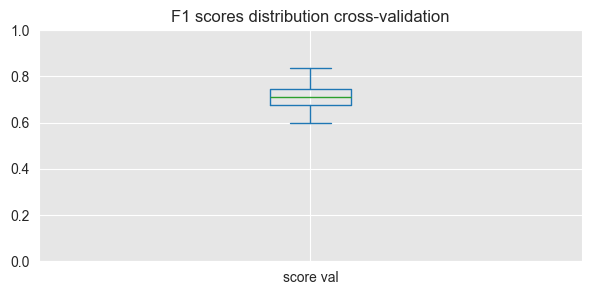

In [ ]:
performances_df = results_from_search(search_engine, performance_metrics_list=['score'])
performances_df.plot(figsize=(7,3),kind='box',y='score val',ylim=[0,1],title="F1 scores distribution / Cross-validation")

In [276]:
# model, model_cfg = get_model('logisticReg', config)
# model_cfg = sample_model_cfg(model_cfg)
# model = instantiate_model(model, **model_cfg)
# model

In [272]:
# model_trained, training_execution_time = fit_model(model, X_train, y_train,return_execution_time=True)
# evaluate(model_trained, X_train, y_train)

In [46]:
len(best_results)

6